# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Import and Clean Wind Data

In [15]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [16]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [17]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [18]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [19]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [20]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [21]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [22]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


## Optimal Separation Size For Individual Features
Here we will use a constant window size of 7 days, but increase the x and y separation up to 43 days (7 + 43 = 50 day max window)

In [65]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
current_separation = pd.Timedelta(0)
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
separations = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_sep = dict()

max_iter = 25000
loss = "log"

current_x_window = pd.Timedelta('7 days')
while current_x_window + current_separation <= max_x_window:
    
    # Windowize
    print("current separation", current_separation)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window, 
        separation=current_separation)
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window,
        separation=current_separation)
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    separations.append(current_separation)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window + current_separation <= max_x_window_size_for_use:
                print("Updating best accuracy and shift size.")
                best_accuracies[col] = accuracy
                best_sep[col] = current_separation
        accuracies[col].append(accuracy)
    current_separation += iteration_delta

current separation 0 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.564179104477612
recall 0.40703517587939697
precision 0.7431192660550459

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6716417910447762
recall 0.5376884422110553
precision 0.856

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6029850746268657
recall 0.4321608040201005
precision 0.8113207547169812

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7970149253731343
recall 0.8391959798994975
precision 0.8226600985221675

Updating best accuracy and window size.
Training model on: ODOSat%
accuracy 0.8029850746268656
recall 0.7587939698492462
precision 0.893491124260355

Updating 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6835820895522388
recall 0.9396984924623115
precision 0.6654804270462633

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.39104477611940297
recall 0.010050251256281407
precision 0.2222222222222222

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5940298507462687
recall 1.0
precision 0.5940298507462687

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6179104477611941
recall 0.4120603015075377
precision 0.8817204301075269

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.44776119402985076
recall 0.11055276381909548
precision 0.7333333333333333

Updating best accuracy and window size.
current separation 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6276276276276276
recall 0.6030927835051546
precision 0.7134146341463414

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7417417417417418
recall 0.6958762886597938
precision 0.8333333333333334

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5765765765765766
recall 0.41237113402061853
precision 0.7476635514018691

Training model on: ODO (mg/L)
accuracy 0.792

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH
accuracy 0.6726726726726727
recall 0.9381443298969072
precision 0.6523297491039427

Training model on: Sp Cond (uS/cm)
accuracy 0.37537537537537535
recall 0.02577319587628866
precision 0.20833333333333334

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5825825825825826
recall 1.0
precision 0.5825825825825826

Training model on: Temp C
accuracy 0.6396396396396397
recall 0.520618556701031
precision 0.7890625

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.46546546546546547
recall 0.28865979381443296
precision 0.5833333333333334

Updating best accuracy and window size.
current separation 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6525679758308157
recall 0.6256410256410256
precision 0.7439024390243902

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7613293051359517
recall 0.7128205128205128
precision 0.8580246913580247

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5921450151057401
recall 0.46153846153846156
precision 0.75

Training model on: ODO (mg/L)
accuracy 0.8126888217522659


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6646525679758308
recall 0.9333333333333333
precision 0.65

Training model on: Sp Cond (uS/cm)
accuracy 0.3202416918429003
recall 0.020512820512820513
precision 0.10526315789473684

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5891238670694864
recall 1.0
precision 0.5891238670694864

Training model on: Temp C
accuracy 0.6676737160120846
recall 0.558974358974359
precision 0.8195488721804511

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4622356495468278
recall 0.3282051282051282
precision 0.5765765765765766

current separation 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.5818181818181818
recall 0.5151515151515151
precision 0.7083333333333334

Training model on: TMIN
accuracy 0.7
recall 0.5656565656565656
precision 0.896

Training model on: Wind Speed
accuracy 0.5666666666666667
recall 0.398989898989899
precision 0.7669902912621359

Training model on: ODO (mg/L)
accuracy 0.796969696969697
recall 0.8181818181818182
precision 0.8393782383419689

Training model on: ODOSat%
accuracy 0.806060606060606
recall 0.7373737373737373
precision 0.9240506329113924

Training mode

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6818181818181818
recall 0.9292929292929293
precision 0.6690909090909091

Training model on: Sp Cond (uS/cm)
accuracy 0.3090909090909091
recall 0.020202020202020204
precision 0.10526315789473684

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6
recall 1.0
precision 0.6

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6545454545454545
recall 0.45454545454545453
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46060606060606063
recall 0.29797979797979796
precision 0.6020408163265306

current separation 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6554878048780488
recall 0.6321243523316062
precision 0.7439024390243902

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7469512195121951
recall 0.7046632124352331
precision 0.8395061728395061

Training model on: Wind Speed
accuracy 0.5853658536585366
recall 0.45077720207253885
precision 0.7435897435897436

Training model on: ODO (mg/L)
accuracy 0.8201219512195121
recall 0.8549222797927462
precision 0.8418367346938775

Updating best accuracy and window size.
Training model on: ODOSat

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6676829268292683
recall 0.927461139896373
precision 0.6532846715328468

Training model on: Sp Cond (uS/cm)
accuracy 0.21951219512195122
recall 0.025906735751295335
precision 0.0684931506849315

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5884146341463414
recall 1.0
precision 0.5884146341463414

Training model on: Temp C
accuracy 0.649390243902439
recall 0.5077720207253886
precision 0.8305084745762712

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.5
recall 0.41450777202072536
precision 0.6106870229007634

Updating best accuracy and window size.
current separation 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6687116564417178
recall 0.6473684210526316
precision 0.75

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.754601226993865
recall 0.7157894736842105
precision 0.8395061728395061

Training model on: Wind Speed
accuracy 0.5736196319018405
recall 0.4421052631578947
precision 0.717948717948718

Training model on: ODO (mg/L)
accuracy 0.8128834355828221
recall 0.8421052631578947
precision 0.837696335078534

Training model on: ODOSat%
accuracy 0.865030

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6625766871165644
recall 0.9263157894736842
precision 0.6470588235294118

Training model on: Sp Cond (uS/cm)
accuracy 0.19325153374233128
recall 0.021052631578947368
precision 0.04938271604938271

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5828220858895705
recall 1.0
precision 0.5828220858895705

Training model on: Temp C
accuracy 0.6809815950920245
recall 0.5789473684210527
precision 0.8208955223880597

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4662576687116564
recall 0.39473684210526316
precision 0.5597014925373134

current separation 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6246153846153846
recall 0.5578947368421052
precision 0.7361111111111112

Training model on: TMIN
accuracy 0.7107692307692308
recall 0.5736842105263158
precision 0.8934426229508197

Training model on: Wind Speed
accuracy 0.5784615384615385
recall 0.4
precision 0.7676767676767676

Training model on: ODO (mg/L)
accuracy 0.7692307692307693
recall 0.7789473684210526
precision 0.8176795580110497

Training model on: ODOSat%
accuracy 0.8523076923076923
recall 0.7894736842105263
precision 0.94936708860759

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.68
recall 0.9315789473684211
precision 0.6604477611940298

Training model on: Sp Cond (uS/cm)
accuracy 0.26153846153846155
recall 0.021052631578947368
precision 0.06896551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5846153846153846
recall 1.0
precision 0.5846153846153846

Training model on: Temp C
accuracy 0.6707692307692308
recall 0.46842105263157896
precision 0.9368421052631579

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46153846153846156
recall 0.3473684210526316
precision 0.5641025641025641

current separation 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6253869969040248
recall 0.5595854922279793
precision 0.75

Training model on: TMIN
accuracy 0.7120743034055728
recall 0.5751295336787565
precision 0.9098360655737705

Training model on: Wind Speed
accuracy 0.5820433436532507
recall 0.43523316062176165
precision 0.7636363636363637

Training model on: ODO (mg/L)
accuracy 0.7523219814241486
recall 0.7512953367875648
precision 0.8192090395480226

Training model on: ODOSat%
accuracy 0.848297213622291
recall 0.7823834196891192
precision 0.9556962025316

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.6594427244582043
recall 0.9015544041450777
precision 0.6566037735849056

Training model on: Sp Cond (uS/cm)
accuracy 0.24458204334365324
recall 0.025906735751295335
precision 0.08196721311475409

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5975232198142415
recall 1.0
precision 0.5975232198142415

Training model on: Temp C
accuracy 0.6687306501547987
recall 0.47150259067357514
precision 0.9479166666666666

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4613003095975232
recall 0.35233160621761656
precision 0.5811965811965812

current separation 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6915887850467289
recall 0.6756756756756757
precision 0.7621951219512195

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.7383177570093458
recall 0.6108108108108108
precision 0.904

Training model on: Wind Speed
accuracy 0.6074766355140186
recall 0.4864864864864865
precision 0.743801652892562

Updating best accuracy and window size.
Training model on: ODO (mg/L)
accuracy 0.7258566978193146
recall 0.7513513513513513
precision 0.7679558011049724

Training model on: ODOSat%

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.5607476635514018
recall 0.5567567567567567
precision 0.6358024691358025

Updating best accuracy and window size.
Training model on: pH
accuracy 0.660436137071651
recall 0.9243243243243243
precision 0.6428571428571429

Training model on: Sp Cond (uS/cm)
accuracy 0.22741433021806853
recall 0.02702702702702703
precision 0.0684931506849315

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH (mV)
accuracy 0.5763239875389408
recall 1.0
precision 0.5763239875389408

Training model on: Temp C
accuracy 0.6822429906542056
recall 0.5675675675675675
precision 0.8267716535433071

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: PRCP
accuracy 0.5607476635514018
recall 0.5567567567567567
precision 0.6358024691358025

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.470404984423676
recall 0.3945945945945946
precision 0.5572519083969466

current separation 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7115987460815048
recall 0.6935483870967742
precision 0.7865853658536586

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8244514106583072
recall 0.7849462365591398
precision 0.9012345679012346

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5768025078369

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.542319749216301
recall 0.5376344086021505
precision 0.625

Training model on: pH
accuracy 0.677115987460815
recall 0.9354838709677419
precision 0.6566037735849056

Training model on: Sp Cond (uS/cm)
accuracy 0.21316614420062696
recall 0.021505376344086023
precision 0.0547945205479452

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5830721003134797
recall 1.0
precision 0.5830721003134797

Training model on: Temp C
accuracy 0.7115987460815048
recall 0.6075268817204301
precision 0.8560606060606061

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5799373040752351
recall 0.6397849462365591
precision 0.6397849462365591

Updating best accuracy and window size.
Training model on: Turbidity (NTU)
accuracy 0.44200626959247646
recall 0.42473118279569894
precision 0.5266666666666666

current separation 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6415094339622641
recall 0.5789473684210527
precision 0.7638888888888888

Training model on: TMIN
accuracy 0.7264150943396226
recall 0.6
precision 0.912

Training model on: Wind Speed
accuracy 0.5754716981132075
recall 0.4263157894736842
precision 0.7570093457943925

Training model on: ODO (mg/L)
accuracy 0.6415094339622641
recall 0.4368421052631579


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5974842767295597
recall 1.0
precision 0.5974842767295597

Training model on: Temp C
accuracy 0.6761006289308176
recall 0.4789473684210526
precision 0.9578947368421052

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4308176100628931
recall 0.32105263157894737
precision 0.5398230088495575

current separation 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7215189873417721
recall 0.7043010752688172
precision 0.7987804878048781

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8227848101265823
recall 0.7849462365591398
precision 0.9012345679012346

Training model on: Wind Speed
accuracy 0.5664556962025317
recall 0.42473118279569894
precision 0.7247706422018348

Training model on: ODO (mg/L)
accuracy 0.5854430379746836
recall 0.3225806451612903
precision 0.9230769230769231

Training model on: ODOSat%
accuracy 0.810126582278

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5886075949367089
recall 1.0
precision 0.5886075949367089

Training model on: Temp C
accuracy 0.6962025316455697
recall 0.543010752688172
precision 0.9017857142857143

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4462025316455696
recall 0.3709677419354839
precision 0.5433070866141733

current separation 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7388535031847133
recall 0.7252747252747253
precision 0.8048780487804879

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8343949044585988
recall 0.8021978021978022
precision 0.9012345679012346

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5828025477707006
recall 0.43956043956043955
precision 0.7339449541284404

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.821656050955414
recall 0.7637362637362637
precision 0.9144736842105263

Training model on: Wind Angle
accuracy 0.4171974522292994
recall 0.17582417582417584
precision 0.49230769230769234

Training model on: rainy
accuracy 0.49363057324840764
recall 0.489010989010989
precision 0.5741935483870968

Training model on: pH
accuracy 0.6847133757961783
recall 0.9230769230769231
precision 0.6640316205533597

Training model on: Sp Cond (uS/cm)
accuracy 0.18789808917197454
recall 0.02197802197802198
precision 0.04938271604938271

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5796178343949044
recall 1.0
precision 0.5796178343949044

Training model on: Temp C
accuracy 0.7006369426751592
recall 0.6043956043956044
precision 0.8333333333333334

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.46178343949044587
recall 0.3956043956043956
precision 0.549618320610687

current separation 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6837060702875399
recall 0.6216216216216216
precision 0.7986111111111112

Training model on: TMIN
accuracy 0.7699680511182109
recall 0.6432432432432432
precision 0.952

Training model on: Wind Speed
accuracy 0.5782747603833865
recall 0.372972972972973
precision 0.8117647058823529

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.6741214057507987
recall 0.4918918918918919
precision 0.9191919191919192

Training model on: Wind Angle
accuracy 0.41533546325878595
recall 0.1783783783783784
precision 0.515625

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7156549520766773
recall 0.9297297297297298
precision 0.6935483870967742

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.24920127795527156
recall 0.021621621621621623
precision 0.06896551724137931

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5910543130990416
recall 1.0
precision 0.5910543130990416

Training model on: Temp C
accuracy 0.6964856230031949
recall 0.4918918918918919
precision 0.9891304347826086

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4281150159744409
recall 0.2756756756756757
precision 0.53125

current separation 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.6881028938906752
recall 0.6256684491978609
precision 0.8125

Training model on: TMIN
accuracy 0.7620578778135049
recall 0.6363636363636364
precision 0.952

Training model on: Wind Speed
accuracy 0.5337620578778135
recall 0.2887700534759358
precision 0.8181818181818182

Training model on: ODO (mg/L)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.5819935691318328
recall 0.3315508021390374
precision 0.9253731343283582

Training model on: Wind Angle
accuracy 0.4212218649517685
recall 0.19786096256684493
precision 0.5522388059701493

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7106109324758842
recall 0.8983957219251337
precision 0.702928870292887

Training model on: Sp Cond (uS/cm)
accuracy 0.24115755627009647
recall 0.026737967914438502
precision 0.0847457627118644

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6012861736334405
recall 1.0
precision 0.6012861736334405

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6816720257234726
recall 0.48128342245989303
precision 0.9782608695652174

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.40514469453376206
recall 0.19786096256684493
precision 0.5138888888888888

current separation 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7799352750809061
recall 0.7637362637362637
precision 0.8475609756097561

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8576051779935275
recall 0.8241758241758241
precision 0.9259259259259259

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.5857605177993528
recall 0.3791208791208791
precision 0.8214285714285714

Training model on: ODO (mg/L)
accuracy 0.3818770226537217
recall 0.06043956043956044
precision 0.3548387096774194

Training 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7346278317152104
recall 0.9560439560439561
precision 0.7016129032258065

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.22653721682847897
recall 0.04945054945054945
precision 0.12

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5889967637540453
recall 1.0
precision 0.5889967637540453

Training model on: Temp C
accuracy 0.7119741100323624
recall 0.5769230769230769
precision 0.8974358974358975

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.47249190938511326
recall 0.3241758241758242
precision 0.5959595959595959

current separation 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8436482084690554
recall 0.842391304347826
precision 0.8908045977011494

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.8566775244299675
recall 0.8206521739130435
precision 0.9320987654320988

Training model on: Wind Speed
accuracy 0.49185667752442996
recall 0.1956521739130435
precision 0.8181818181818182

Training model on: ODO (mg/L)
accuracy 0.36482084690553745
recall 0.11956521739130435
precision 0.4

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.48534201954397393
recall 0.375
precision 0.6160714285714286

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.755700325732899
recall 0.9728260869565217
precision 0.7188755020080321

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.22149837133550487
recall 0.04891304347826087
precision 0.1232876712328767

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.5993485342019544
recall 1.0
precision 0.5993485342019544

Training model on: Temp C
accuracy 0.745928338762215
recall 0.657608695652174
precision 0.8897058823529411

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4234527687296417
recall 0.22826086956521738
precision 0.5454545454545454

current separation 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.738562091503268
recall 0.6702127659574468
precision 0.875

Training model on: TMIN
accuracy 0.7549019607843137
recall 0.6329787234042553
precision 0.952

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38235294117647056
recall 0.10106382978723404
precision 0.48717948717948717

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.4019607843137255
recall 0.18085106382978725
precision 0.5396825396825397

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.8006535947712419
recall 0.8723404255319149
precision 0.8159203980099502

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.28431372549019607
recall 0.03723404255319149
precision 0.15555555555555556

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6143790849673203
recall 1.0
precision 0.6143790849673203

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6830065359477124
recall 0.48936170212765956
precision 0.989247311827957

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.3790849673202614
recall 0.0
precision 0.0

current separation 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8223684210526315
recall 0.7989130434782609
precision 0.8963414634146342

Training model on: TMIN
accuracy 0.8223684210526315
recall 0.7934782608695652
precision 0.9012345679012346

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3684210526315789
recall 0.14673913043478262
precision 0.43548387096774194

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.40460526315789475
recall 0.1793478260869565
precision 0.5238095238095238

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7894736842105263
recall 0.9021739130434783
precision 0.7830188679245284

Training model on: Sp Cond (uS/cm)
accuracy 0.2138157894736842
recall 0.04891304347826087
precision 0.1232876712328767

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6052631578947368
recall 1.0
precision 0.6052631578947368

Training model on: Temp C
accuracy 0.7105263157894737
recall 0.5815217391304348
precision 0.9067796610169492

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.4868421052631579
recall 0.4945652173913043
precision 0.5909090909090909

Training model on: Turbidity (NTU)
accuracy 0.40460526315789475
recall 0.04891304347826087
precision 0.6

current separation 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8344370860927153
recall 0.8131868131868132
precision 0.9024390243902439

Training model on: TMIN
accuracy 0.8211920529801324
recall 0.7967032967032966
precision 0.8950617283950617

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3708609271523179
recall 0.18681318681318682
precision 0.4473684210526316

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.39403973509933776
recall 0.15384615384615385
precision 0.49122807017543857

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.7980132450331126
recall 0.8846153846153846
precision 0.8009950248756219

Training model on: Sp Cond (uS/cm)
accuracy 0.18211920529801323
recall 0.04395604395604396
precision 0.09876543209876543

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6026490066225165
recall 1.0
precision 0.6026490066225165

Training model on: Temp C
accuracy 0.7615894039735099
recall 0.6758241758241759
precision 0.9044117647058824

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.4470198675496689
recall 0.19230769230769232
precision 0.6363636363636364

current separation 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.770764119601329
recall 0.7027027027027027
precision 0.9027777777777778

Training model on: TMIN
accuracy 0.7375415282392026
recall 0.6162162162162163
precision 0.9344262295081968

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38205980066445183
recall 0.10270270270270271
precision 0.48717948717948717

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.37209302325581395
recall 0.11891891891891893
precision 0.4583333333333333

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.49169435215946844
recall 0.2
precision 0.8809523809523809

Training model on: Sp Cond (uS/cm)
accuracy 0.3023255813953488
recall 0.043243243243243246
precision 0.1951219512195122

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6146179401993356
recall 1.0
precision 0.6146179401993356

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6877076411960132
recall 0.4972972972972973
precision 0.989247311827957

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

current separation 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7558528428093646
recall 0.6898395721925134
precision 0.8958333333333334

Training model on: TMIN
accuracy 0.745819397993311
recall 0.6310160427807486
precision 0.944

Training model on: Wind Speed
accuracy 0.3411371237458194
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3612040133779264
recall 0.11764705882352941
precision 0.4583333333333333

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.3712374581939799
recall 0.0962566844919786
precision 0.4864864864864865

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: pH


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.19732441471571907
recall 0.053475935828877004
precision 0.136986301369863

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6254180602006689
recall 1.0
precision 0.6254180602006689

Updating best accuracy and window size.
Training model on: Temp C
accuracy 0.6989966555183946
recall 0.5240641711229946
precision 0.98989898989899

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

current separation 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8181818181818182
recall 0.8021978021978022
precision 0.8902439024390244

Training model on: TMIN
accuracy 0.7845117845117845
recall 0.7692307692307693
precision 0.8641975308641975

Training model on: Wind Speed
accuracy 0.3434343434343434
recall 0.03296703296703297
precision 0.24

Training model on: ODO (mg/L)
accuracy 0.3333333333333333
recall 0.15934065934065933
precision 0.3918918918918919

Training model on: ODOSat%
accuracy 0.3434343434343434
recall 0.038461538461538464
precision 0.25925925925925924

Training model on: Wind Angle
accuracy 0.37373737373737376
recall 0.0
precision 0.0

Training model on: rainy

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.16161616161616163
recall 0.07142857142857142
precision 0.13978494623655913

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6127946127946128
recall 1.0
precision 0.6127946127946128

Training model on: Temp C
accuracy 0.8013468013468014
recall 0.7142857142857143
precision 0.948905109489051

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

current separation 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7966101694915254
recall 0.8097826086956522
precision 0.8563218390804598

Training model on: TMIN
accuracy 0.7864406779661017
recall 0.8043478260869565
precision 0.8457142857142858

Training model on: Wind Speed
accuracy 0.3423728813559322
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3254237288135593
recall 0.19021739130434784
precision 0.4117647058823529

Training model on: ODOSat%
accuracy 0.29152542372881357
recall 0.07065217391304347
precision 0.2549019607843137

Training model on: Wind Angle
accuracy 0.41694915254237286
recall 0.13043478260869565
precision 0.6666666666666666

Training mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.21694915254237288
recall 0.18478260869565216
precision 0.2956521739130435

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: pH (mV)
accuracy 0.6237288135593221
recall 1.0
precision 0.6237288135593221

Training model on: Temp C
accuracy 0.823728813559322
recall 0.7934782608695652
precision 0.9125

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5796610169491525
recall 0.75
precision 0.6388888888888888

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

current separation 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7619047619047619
recall 0.6968085106382979
precision 0.9097222222222222

Training model on: TMIN
accuracy 0.7755102040816326
recall 0.7553191489361702
precision 0.8765432098765432

Training model on: Wind Speed
accuracy 0.32653061224489793
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.30272108843537415
recall 0.10106382978723404
precision 0.34545454545454546

Training model on: ODOSat%


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: Wind Angle
accuracy 0.40816326530612246
recall 0.13297872340425532
precision 0.6944444444444444

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: pH
accuracy 0.3401360544217687
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.1870748299319728
recall 0.0797872340425532
precision 0.18518518518518517

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7210884353741497
recall 0.5904255319148937
precision 0.9568965517241379

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36054421768707484
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5918367346938775
recall 0.6595744680851063
precision 0.6888888888888889

Training model on: Turbidity (NTU)
accuracy 0.3877551020408163
recall 0.11170212765957446
precision 0.6176470588235294

current separation 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.773972602739726
recall 0.7934782608695652
precision 0.8390804597701149

Training model on: TMIN
accuracy 0.7876712328767124
recall 0.7989130434782609
precision 0.8546511627906976

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3356164383561644
recall 0.1793478260869565
precision 0.4342105263157895

Training model on: ODOSat%
accuracy 0.339041095890411
recall 0.05434782608695652
precision 0.3448275862068966

Training model on: Wind Angle
accuracy 0.4383561643835616
recall 0.3695652173913043
precision 0.5862068965517241

Training model on: rainy
accuracy 0.5068493150684932
recall 0.5271739130434783
precision 0.6298701298701299

Training model on: pH
accuracy 0.3253424657534247
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.1678082191780822
recall 0.09782608695652174
precision 0.18947368421052632

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7773972602739726
recall 0.7010869565217391
precision 0.9280575539568345

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.5958904109589042
recall 0.7663043478260869
precision 0.6527777777777778

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3698630136986301
recall 0.0
precision 0.0

current separation 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7724137931034483
recall 0.7967032967032966
precision 0.8333333333333334

Training model on: TMIN
accuracy 0.7862068965517242
recall 0.7967032967032966
precision 0.8529411764705882

Training model on: Wind Speed
accuracy 0.4206896551724138
recall 0.07692307692307693
precision 1.0

Training model on: ODO (mg/L)
accuracy 0.32413793103448274
recall 0.18681318681318682
precision 0.4146341463414634

Training model on: ODOSat%
accuracy 0.32068965517241377
recall 0.08241758241758242
precision 0.3333333333333333

Training model on: Wind Angle
accuracy 0.49310344827586206
recall 0.46703296703296704
precision 0.629629629629

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7931034482758621
recall 0.7637362637362637
precision 0.8910256410256411

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6206896551724138
recall 0.7912087912087912
precision 0.6666666666666666

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3724137931034483
recall 0.0
precision 0.0

current separation 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7474048442906575
recall 0.6918918918918919
precision 0.8888888888888888

Training model on: TMIN
accuracy 0.754325259515571
recall 0.745945945945946
precision 0.8518518518518519

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.370242214532872
recall 0.1891891891891892
precision 0.5223880597014925

Training model on: ODOSat%
accuracy 0.32525951557093424
recall 0.043243243243243246
precision 0.3076923076923077

Training model on: Wind Angle
accuracy 0.43252595155709345
recall 0.3783783783783784
precision 0.5882352941176471

Training model on: rainy
accuracy 0.5397923875432526
recall 0.5567567567567567
precision 0.6688311688311688

Training model on: pH
accuracy 0.3079584775086505
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.17647058823529413
recall 0.10810810810810811
precision 0.21505376344086022

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7162629757785467
recall 0.5783783783783784
precision 0.963963963963964

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.643598615916955
recall 0.8054054054054054
precision 0.6898148148148148

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.35986159169550175
recall 0.0
precision 0.0

current separation 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7804878048780488
recall 0.7700534759358288
precision 0.8780487804878049

Training model on: TMIN
accuracy 0.759581881533101
recall 0.7486631016042781
precision 0.8641975308641975

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.3693379790940767
recall 0.20320855614973263
precision 0.5428571428571428

Training model on: ODOSat%
accuracy 0.30662020905923343
recall 0.058823529411764705
precision 0.3235294117647059

Training model on: Wind Angle
accuracy 0.43902439024390244
recall 0.42245989304812837
precision 0.5984848484848485

Training model on: rainy
accuracy 0.5400696864111498
recall 0.5561497326203209
precision 0.6797385620915033

Training model on: pH
accuracy 0.28222996515679444
recall 0.026737967914438502
precision 0.1724137931034483

Training model on: Sp Cond (uS/cm)
accuracy 0.16376306620209058
recall 0.10695187165775401
precision 0.21505376344086022

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7386759581881533
recall 0.6417112299465241
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6515679442508711
recall 0.8074866310160428
precision 0.7023255813953488

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34843205574912894
recall 0.0
precision 0.0

current separation 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7614035087719299
recall 0.7912087912087912
precision 0.8275862068965517

Training model on: TMIN
accuracy 0.7578947368421053
recall 0.7637362637362637
precision 0.8424242424242424

Training model on: Wind Speed
accuracy 0.45263157894736844
recall 0.18681318681318682
precision 0.8095238095238095

Training model on: ODO (mg/L)
accuracy 0.35789473684210527
recall 0.22527472527472528
precision 0.4939759036144578

Training model on: ODOSat%
accuracy 0.24912280701754386
recall 0.17032967032967034
precision 0.32978723404255317

Training model on: Wind Angle
accuracy 0.48771929824561405
recall 0.5384615384615384
precisi

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7543859649122807
recall 0.7362637362637363
precision 0.8589743589743589

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.36140350877192984
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6596491228070176
recall 0.8186813186813187
precision 0.6995305164319249

Training model on: Turbidity (NTU)
accuracy 0.4
recall 0.3021978021978022
precision 0.5555555555555556

current separation 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7597173144876325
recall 0.8043478260869565
precision 0.8222222222222222

Training model on: TMIN
accuracy 0.7491166077738516
recall 0.75
precision 0.8466257668711656

Training model on: Wind Speed
accuracy 0.6749116607773852
recall 0.8913043478260869
precision 0.6949152542372882

Training model on: ODO (mg/L)
accuracy 0.35335689045936397
recall 0.266304347826087
precision 0.5051546391752577

Training mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3498233215547703
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7703180212014135
recall 0.8043478260869565
precision 0.8361581920903954

Training model on: SNOW
accuracy 0.6501766784452296
recall 1.0
precision 0.6501766784452296

Training model on: PRCP
accuracy 0.6925795053003534
recall 0.8586956521739131
precision 0.7214611872146118

Training model on: Turbidity (NTU)
accuracy 0.5053003533568905
recall 0.625
precision 0.6182795698924731

current separation 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7730496453900709
recall 0.7659574468085106
precision 0.8780487804878049

Training model on: TMIN
accuracy 0.7588652482269503
recall 0.75
precision 0.8703703703703703

Training model on: Wind Speed
accura

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6985815602836879
recall 0.6276595744680851
precision 0.8872180451127819

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6808510638297872
recall 0.8191489361702128
precision 0.7333333333333333

Training model on: Turbidity (NTU)
accuracy 0.3900709219858156
recall 0.34574468085106386
precision 0.5701754385964912

current separation 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7714285714285715
recall 0.7989130434782609
precision 0.8448275862068966

Training model on: TMIN
accuracy 0.7535714285714286
recall 0.7554347826086957
precision 0.852760736196319

Training model on: Wind Speed


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.38571428571428573
recall 0.2554347826086957
precision 0.573170731707317

Training model on: ODOSat%
accuracy 0.2785714285714286
recall 0.19021739130434784
precision 0.3977272727272727

Training model on: Wind Angle
accuracy 0.5178571428571429
recall 0.5543478260869565
precision 0.6580645161290323

Training model on: rainy
accuracy 0.5714285714285714
recall 0.5706521739130435
precision 0.7191780821917808

Training model on: pH
accuracy 0.26071428571428573
recall 0.02717391304347826
precision 0.15151515151515152

Training model on: Sp Cond (uS/cm)
accuracy 0.2892857142857143
recall 0.29347826086956524
precision 0.43902439024390244

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7035714285714286
recall 0.6521739130434783
precision 0.8633093525179856

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34285714285714286
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6857142857142857
recall 0.8260869565217391
precision 0.7307692307692307

Training model on: Turbidity (NTU)
accuracy 0.4392857142857143
recall 0.44021739130434784
precision 0.6

current separation 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7769784172661871
recall 0.8241758241758241
precision 0.8333333333333334

Training model on: TMIN
accuracy 0.7589928057553957
recall 0.7637362637362637
precision 0.852760736196319

Training model on: Wind Speed
accuracy 0.4136690647482014
recall 0.31868131868131866
precision 0.5979381443298969

Training model on: ODO (mg/L)
accuracy 0.35611510791366907
recall 0.2692307692307692
precision 0.51578947368421

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7482014388489209
recall 0.7472527472527473
precision 0.85

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.34532374100719426
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7122302158273381
recall 0.8681318681318682
precision 0.7383177570093458

Training model on: Turbidity (NTU)
accuracy 0.5143884892086331
recall 0.6043956043956044
precision 0.6358381502890174

current separation 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7436823104693141
recall 0.6972972972972973
precision 0.8958333333333334

Training model on: TMIN
accuracy 0.7653429602888087
recall 0.7621621621621621
precision 0.8703703703703703

Training model on: Wind Speed
accuracy 0.2743682310469314
recall 0.010810810810810811
precision 0.1

Training model on: ODO (mg/L)
accuracy 0.4043321299638989
recall 0.2594594594594595
precision 0.63157894736842

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6859205776173285
recall 0.5675675675675675
precision 0.9375

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.33212996389891697
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6823104693140795
recall 0.8162162162162162
precision 0.7365853658536585

Training model on: Turbidity (NTU)
accuracy 0.36101083032490977
recall 0.05945945945945946
precision 0.7857142857142857

current separation 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8072727272727273
recall 0.7967914438502673
precision 0.9085365853658537

Training model on: TMIN
accuracy 0.7636363636363637
recall 0.7593582887700535
precision 0.8765432098765432

Training model on: Wind Speed
accuracy 0.2909090909090909
recall 0.0053475935828877
precision 0.1

Training model on: ODO (mg/L)
accuracy 0.41454545454545455
recall 0.27807486631016043
precision 0.666666666666

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7054545454545454
recall 0.5989304812834224
precision 0.9491525423728814

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.32
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.6872727272727273
recall 0.8128342245989305
precision 0.7487684729064039

Training model on: Turbidity (NTU)
accuracy 0.3890909090909091
recall 0.3155080213903743
precision 0.5959595959595959

current separation 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8241758241758241
recall 0.8626373626373627
precision 0.8722222222222222

Training model on: TMIN
accuracy 0.7619047619047619
recall 0.7692307692307693
precision 0.8588957055214724

Training model on: Wind Speed
accuracy 0.6190476190476191
recall 0.7967032967032966
precision 0.6839622641509434

Training model on: ODO (mg/L)
accuracy 0.39194139194139194
recall 0.3131868131868132
precision 0.581632653061224

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3333333333333333
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7509157509157509
recall 0.7582417582417582
precision 0.8518518518518519

Training model on: SNOW
accuracy 0.6666666666666666
recall 1.0
precision 0.6666666666666666

Training model on: PRCP
accuracy 0.6813186813186813
recall 0.8351648351648352
precision 0.7272727272727273

Training model on: Turbidity (NTU)
accuracy 0.5457875457875457
recall 0.6373626373626373
precision 0.6666666666666666

current separation 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8339483394833949
recall 0.9402173913043478
precision 0.8357487922705314

Training model on: TMIN
accuracy 0.7675276752767528
recall 0.782608695652174
precision 0.8622754491017964

Training m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3210332103321033
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7896678966789668
recall 0.8586956521739131
precision 0.8359788359788359

Training model on: SNOW
accuracy 0.6789667896678967
recall 1.0
precision 0.6789667896678967

Training model on: PRCP
accuracy 0.6863468634686347
recall 0.8369565217391305
precision 0.7368421052631579

Training model on: Turbidity (NTU)
accuracy 0.6678966789667896
recall 0.8206521739130435
precision 0.7259615384615384

current separation 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8222222222222222
recall 0.8085106382978723
precision 0.926829268292683

Training model on: TMIN
accuracy 0.762962962962963
recall 0.7553191489361702
precision 0.8875

Training model on: Wind

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.45185185185185184
recall 0.324468085106383
precision 0.7439024390243902

Training model on: ODOSat%
accuracy 0.34074074074074073
recall 0.2978723404255319
precision 0.5490196078431373

Training model on: Wind Angle
accuracy 0.5296296296296297
recall 0.5478723404255319
precision 0.7103448275862069

Training model on: rainy
accuracy 0.5185185185185185
recall 0.5159574468085106
precision 0.7132352941176471

Training model on: pH
accuracy 0.22592592592592592
recall 0.03723404255319149
precision 0.2

Training model on: Sp Cond (uS/cm)
accuracy 0.3037037037037037
recall 0.31382978723404253
precision 0.5

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7037037037037037
recall 0.6382978723404256
precision 0.9090909090909091

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3037037037037037
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.674074074074074
recall 0.7925531914893617
precision 0.7525252525252525

Training model on: Turbidity (NTU)
accuracy 0.42592592592592593
recall 0.3882978723404255
precision 0.6460176991150443

current separation 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7947761194029851
recall 0.8586956521739131
precision 0.8449197860962567

Training model on: TMIN
accuracy 0.7313432835820896
recall 0.7336956521739131
precision 0.8544303797468354

Training model on: Wind Speed
accuracy 0.6865671641791045
recall 0.9728260869565217
precision 0.6937984496124031

Training model on: ODO (mg/L)
accuracy 0.4253731343283582
recall 0.34782608695652173
precision 0.6

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31343283582089554
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7910447761194029
recall 0.8315217391304348
precision 0.8595505617977528

Training model on: SNOW
accuracy 0.6865671641791045
recall 1.0
precision 0.6865671641791045

Training model on: PRCP
accuracy 0.6865671641791045
recall 0.8315217391304348
precision 0.7427184466019418

Training model on: Turbidity (NTU)
accuracy 0.5597014925373134
recall 0.6413043478260869
precision 0.6941176470588235

current separation 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.8195488721804511
recall 0.9230769230769231
precision 0.8316831683168316

Training model on: TMIN
accuracy 0.7593984962406015
recall 0.8186813186813187
precision 0.8277777777777777

Training

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3157894736842105
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7669172932330827
recall 0.8296703296703297
precision 0.8296703296703297

Training model on: SNOW
accuracy 0.6842105263157895
recall 1.0
precision 0.6842105263157895

Training model on: PRCP
accuracy 0.6842105263157895
recall 0.8351648351648352
precision 0.7378640776699029

Training model on: Turbidity (NTU)
accuracy 0.631578947368421
recall 0.7252747252747253
precision 0.7333333333333333

current separation 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7962264150943397
recall 0.7989130434782609
precision 0.8963414634146342

Training model on: TMIN
accuracy 0.7094339622641509
recall 0.7119565217391305
precision 0.8451612903225807

Training m

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: pH (mV)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.7358490566037735
recall 0.6793478260869565
precision 0.9191176470588235

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30566037735849055
recall 0.0
precision 0.0

Training model on: PRCP
accuracy 0.7018867924528301
recall 0.8315217391304348
precision 0.7611940298507462

Training model on: Turbidity (NTU)
accuracy 0.5849056603773585
recall 0.625
precision 0.7371794871794872

current separation 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.7908745247148289
recall 0.842391304347826
precision 0.856353591160221

Training model on: TMIN
accuracy 0.7680608365019012
recall 0.8586956521739131
precision 0.8186528497409327

Training model on: Wind Speed
accuracy 0.5741444866920152
recall 0.717391304347826
precision 0.6875

Training model on: ODO (mg/L)
accuracy 0.4524714828897338
recall 0.3695652173913043
precision 0.7083333333333334

Training mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.30038022813688214
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.8060836501901141
recall 0.8315217391304348
precision 0.884393063583815

Training model on: SNOW
accuracy 0.6996197718631179
recall 1.0
precision 0.6996197718631179

Training model on: PRCP
accuracy 0.7224334600760456
recall 0.8478260869565217
precision 0.7761194029850746

Training model on: Turbidity (NTU)
accuracy 0.6159695817490495
recall 0.6684782608695652
precision 0.754601226993865

current separation 43 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: TMAX
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: TMIN
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: Wind Speed
accuracy 0.708

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.31417624521072796
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.789272030651341
recall 0.9385474860335196
precision 0.7924528301886793

Training model on: SNOW
accuracy 0.685823754789272
recall 1.0
precision 0.685823754789272

Training model on: PRCP
accuracy 0.7318007662835249
recall 1.0
precision 0.7188755020080321

Training model on: Turbidity (NTU)
accuracy 0.6973180076628352
recall 0.7988826815642458
precision 0.7688172043010753



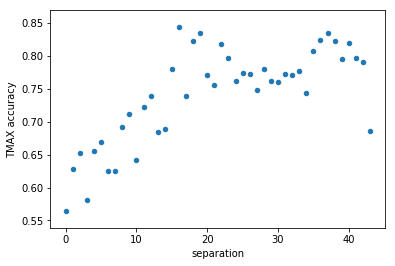

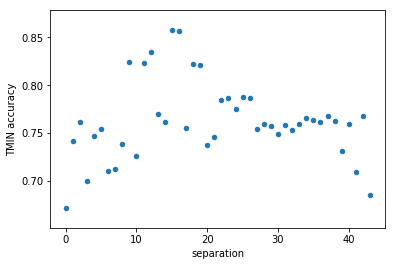

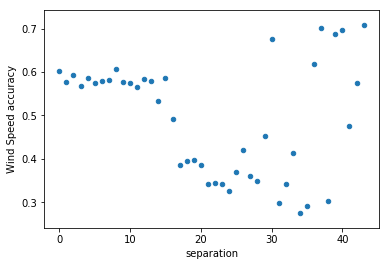

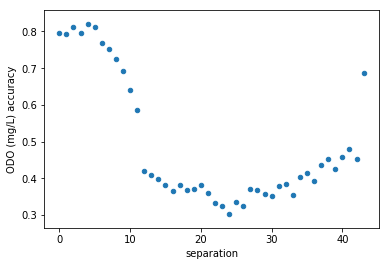

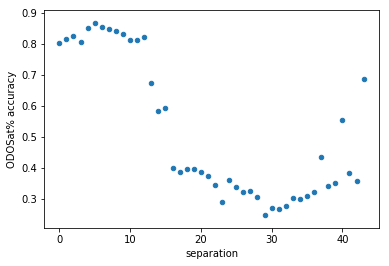

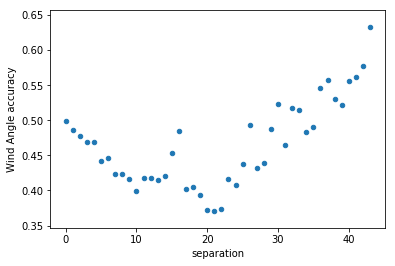

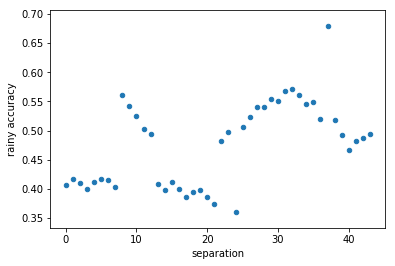

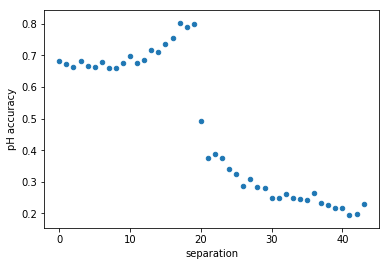

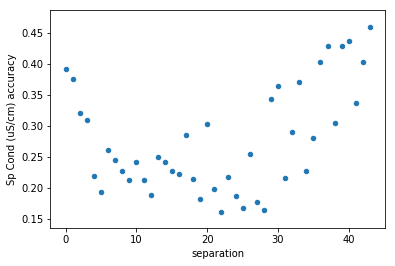

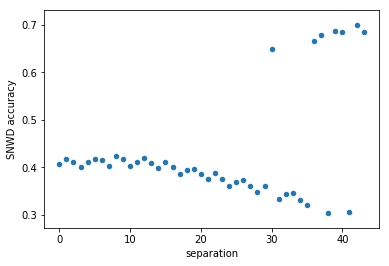

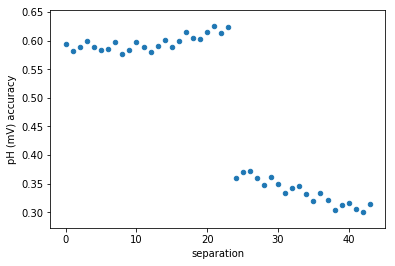

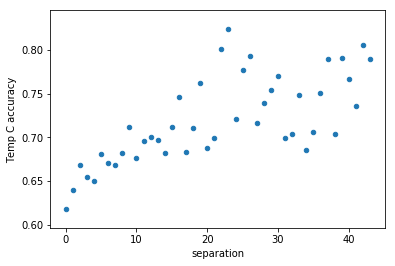

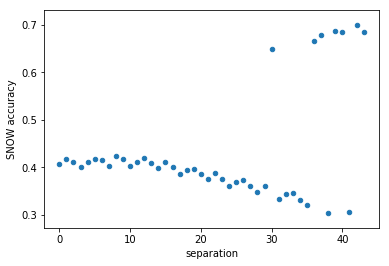

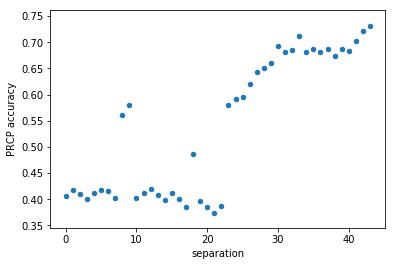

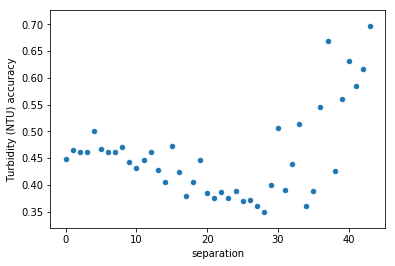

In [67]:
# Plot the accuracies vs separation size for each column
seps = [x.days for x in separations]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "separation": seps})
    df.plot(kind="scatter", y=col + " accuracy", x="separation")

## Greedy Custom Separation Size
Create a greedy model using the best custom separation sizes found above.

In [70]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, sep in best_sep.items():
    print(col, sep)
    parameters[col] = {'separation':sep, 'x_win_size':pd.Timedelta('7 days')}

# Windowize
print("Windowizing 2017 data set:", train_index)
train = hf.windowize(train_dfs[train_index], 'datetime', 
                     target_column, custom_parameters=parameters)
print("Windowizing 2018 data set:", test_index)
test = hf.windowize(test_dfs[test_index], 'datetime', 
                    target_column, custom_parameters=parameters)
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

TMAX 16 days 00:00:00
TMIN 15 days 00:00:00
Wind Speed 8 days 00:00:00
ODO (mg/L) 4 days 00:00:00
ODOSat% 5 days 00:00:00
Wind Angle 0 days 00:00:00
rainy 8 days 00:00:00
pH 17 days 00:00:00
Sp Cond (uS/cm) 0 days 00:00:00
SNWD 8 days 00:00:00
pH (mV) 21 days 00:00:00
Temp C 23 days 00:00:00
SNOW 8 days 00:00:00
PRCP 9 days 00:00:00
Turbidity (NTU) 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model with: TMAX
Accuracy 0.8169491525423729
Recall: 0.842391304347826
Precision 0.8611111111111112
Confusion Matrix:
 [[ 86  25]
 [ 29 155]]

Training model with: TMIN
Accuracy 0.8305084745762712
Recall: 0.842391304347826
Precision 0.8806818181818182
Confusion Matrix:
 [[ 90  21]
 [ 29 155]]

Training model with: Wind Speed
Accuracy 0.5457627118644067
Recall: 0.5163

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.376271186440678
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[111   0]
 [184   0]]

Training model with: pH (mV)
Accuracy 0.6237288135593221
Recall: 1.0
Precision 0.6237288135593221
Confusion Matrix:
 [[  0 111]
 [  0 184]]

Training model with: Temp C
Accuracy 0.823728813559322
Recall: 0.7880434782608695
Precision 0.9177215189873418
Confusion Matrix:
 [[ 98  13]
 [ 39 145]]

Training model with: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.376271186440678
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[111   0]
 [184   0]]

Training model with: PRCP
Accuracy 0.6305084745762712
Recall: 0.7608695652173914
Precision 0.6829268292682927
Confusion Matrix:
 [[ 46  65]
 [ 44 140]]

Training model with: Turbidity (NTU)
Accuracy 0.5084745762711864
Recall: 0.6467391304347826
Precision 0.5979899497487438
Confusion Matrix:
 [[ 31  80]
 [ 65 119]]

ODOSat% metric value: 0.8779661016949153
ODO (mg/L) metric value: 0.8745762711864407
TMIN metric value: 0.8305084745762712
Temp C metric value: 0.823728813559322
TMAX metric value: 0.8169491525423729
pH metric value: 0.7491525423728813
PRCP metric value: 0.6305084745762712
pH (mV) metric value: 0.6237288135593221
rainy metric value: 0.5627118644067797
Wind Speed metric value: 0.5457627118644067
Turbidity (NTU) metric value: 0.5084745762711864
Wind Angle metric value: 0.47796610169491527
SNWD metric value: 0.376271186440678
SNOW metric value: 0.376271186440678
Sp Cond (uS/cm) metri

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'pH', 'PRCP', 'pH (mV)', 'rainy', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'pH', 'PRCP', 'pH (mV)', 'rainy', 'Wind Speed', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8779661016949153
Test model recall: 0.8586956521739131
Test model precision: 0.9404761904761905

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8745762711864407
Test model recall: 0.8586956521739131
Test model precision: 0.9349112426035503

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.864406779661017
Test model recall: 0.8532608695652174
Test model precision: 0.9235294117647059

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8779661016949153
Test model recall: 0